In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt


%config InlineBackend.figure_format = 'retina' # для более четкой отрисовки графиков

In [2]:
ds = pd.read_csv('credit_data.csv', header=None) # загружаем данные
ds.columns = ['a_'+str(i) for i in range(ds.shape[1]-1)] + ['target'] # пронумеруем признаки и обозначим целевой признак
ds['target'] = ds['target'].map({'+':1, '-':0}) # приведем целевую переменную к численному виду

In [3]:
ds # посмотри на датасет

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,target
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,0
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,0
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,0
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,0


Проведем краткий стандартный анализ датасета и подготовим его для применения алгоритмой машинного обучения:

In [4]:
ds.dtypes

a_0        object
a_1        object
a_2       float64
a_3        object
a_4        object
a_5        object
a_6        object
a_7       float64
a_8        object
a_9        object
a_10        int64
a_11       object
a_12       object
a_13       object
a_14        int64
target      int64
dtype: object

Кажется, что признаки 'a_1' и 'a_13' должны быть также числовыми - приведем их к этому виду:

In [5]:
ds['a_1'] = pd.to_numeric(ds['a_1'], errors='coerce')
ds['a_13'] = pd.to_numeric(ds['a_13'], errors='coerce')

In [6]:
ds.head()

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,target
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [7]:
ds['target'].value_counts() # --> датасет сбаллансированный

0    383
1    307
Name: target, dtype: int64

In [8]:
ds_dummies = pd.get_dummies(ds) # закодируем категориальные признаки

Разделим данные на тренировочную и тестовую выборки: обучение и валидацию будем проводить на тренировочной выборки, а финальную проверку качества модели на тестовой выборке.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(ds_dummies.drop(['target'], axis=1), 
                                                    ds_dummies['target'],
                                                    test_size=0.2,
                                                    random_state=17,
                                                    shuffle=True
                                                   )

In [10]:
print('Размер тренировочной выборки: {}\nРазмер тестовой выборки: {}'.format(x_train.shape, x_test.shape))

Размер тренировочной выборки: (552, 51)
Размер тестовой выборки: (138, 51)


In [11]:
x_train.isna().sum()

a_1       10
a_2        0
a_7        0
a_10       0
a_13      11
a_14       0
a_0_?      0
a_0_a      0
a_0_b      0
a_3_?      0
a_3_l      0
a_3_u      0
a_3_y      0
a_4_?      0
a_4_g      0
a_4_gg     0
a_4_p      0
a_5_?      0
a_5_aa     0
a_5_c      0
a_5_cc     0
a_5_d      0
a_5_e      0
a_5_ff     0
a_5_i      0
a_5_j      0
a_5_k      0
a_5_m      0
a_5_q      0
a_5_r      0
a_5_w      0
a_5_x      0
a_6_?      0
a_6_bb     0
a_6_dd     0
a_6_ff     0
a_6_h      0
a_6_j      0
a_6_n      0
a_6_o      0
a_6_v      0
a_6_z      0
a_8_f      0
a_8_t      0
a_9_f      0
a_9_t      0
a_11_f     0
a_11_t     0
a_12_g     0
a_12_p     0
a_12_s     0
dtype: int64

In [12]:
x_train['a_1'].fillna(x_train['a_1'].median(), inplace=True) # заполним пропуски медианными значениями
x_train['a_13'].fillna(x_train['a_1'].median(), inplace=True)

Одни из преимуществ алгоритма случайного дерева - это невосриимчивость к разным масштабам данных, поэтому в данном случае нам не нужно проводить нормализацию/стандартизацию, а сразу перейдем к обучению модели:

In [13]:
tree = DecisionTreeClassifier() # пока оставим дефолтные параметры
skf = StratifiedKFold(n_splits=7) # схема для кросс-валидации

cv_score = cross_val_score(tree, x_train, y_train, cv=skf, n_jobs=-1) # прогоняем модель на кросс-валидации
print('Точность модели на кросс-валидации: %.3f+-%.3f'% (np.mean(cv_score), np.std(cv_score)))

Точность модели на кросс-валидации: 0.808+-0.048


Мы сразу получили неплохую точность с базовыми параметрами модели, теперь попробуем настроить модель на кросс-валидации:

In [14]:
params = {'max_depth': (5, 9, 15), 'min_samples_split': (2, 4, 6), 'min_samples_leaf': (1,2,3)}
tree_grid = GridSearchCV(tree, param_grid=params, scoring='accuracy', n_jobs=-1, cv=skf)
tree_grid.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': (5, 9, 15), 'min_samples_leaf': (1, 2, 3),
                         'min_samples_split': (2, 4, 6)},
             scoring='accuracy')

In [15]:
print('Лучшая модель на кросс-валидации с параметрами {} и результатом {}'.format(tree_grid.best_params_, 
                                                                        tree_grid.best_score_,))

best_model = tree_grid.best_estimator_

Лучшая модель на кросс-валидации с параметрами {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6} и результатом 0.8406361570918531


Теперь посмотрим как наша модель отработает на тестовой выборке

In [16]:
x_test.isna().sum()

a_1       2
a_2       0
a_7       0
a_10      0
a_13      2
a_14      0
a_0_?     0
a_0_a     0
a_0_b     0
a_3_?     0
a_3_l     0
a_3_u     0
a_3_y     0
a_4_?     0
a_4_g     0
a_4_gg    0
a_4_p     0
a_5_?     0
a_5_aa    0
a_5_c     0
a_5_cc    0
a_5_d     0
a_5_e     0
a_5_ff    0
a_5_i     0
a_5_j     0
a_5_k     0
a_5_m     0
a_5_q     0
a_5_r     0
a_5_w     0
a_5_x     0
a_6_?     0
a_6_bb    0
a_6_dd    0
a_6_ff    0
a_6_h     0
a_6_j     0
a_6_n     0
a_6_o     0
a_6_v     0
a_6_z     0
a_8_f     0
a_8_t     0
a_9_f     0
a_9_t     0
a_11_f    0
a_11_t    0
a_12_g    0
a_12_p    0
a_12_s    0
dtype: int64

In [17]:
x_test['a_1'].fillna(x_test['a_1'].median(), inplace=True) # заполним пропуски медианными значениями
x_test['a_13'].fillna(x_test['a_1'].median(), inplace=True)

In [18]:
best_model.fit(x_train, y_train)
print('Точность модели на тестовой выборке: %.3f' % accuracy_score(y_test, best_model.predict(x_test)))

Точность модели на тестовой выборке: 0.833


Точность на тестовой выборке близка к точности на валидации, следовательно, наша модель не переобучается и адекватно предсказывает данные, которые никогда не видела. 

Также наглядным инструментом, чтобы оценить качество работы модели будет confusion_matrix, мы сможем увидеть где и как часто модель ошибается:

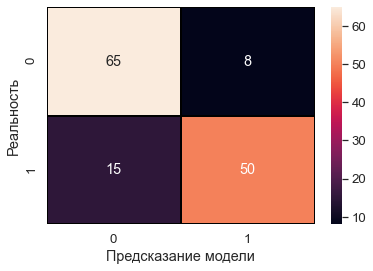

In [19]:
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix(y_test, best_model.predict(x_test)), 
            annot=True, 
            fmt = '.3g',
            linewidths=0.1,
            linecolor='black'
           );
plt.xlabel('Предсказание модели')
plt.ylabel('Реальность');

Также дерево решений является простым в интерпретации решением, шаги решения можно даже визцуализировать:

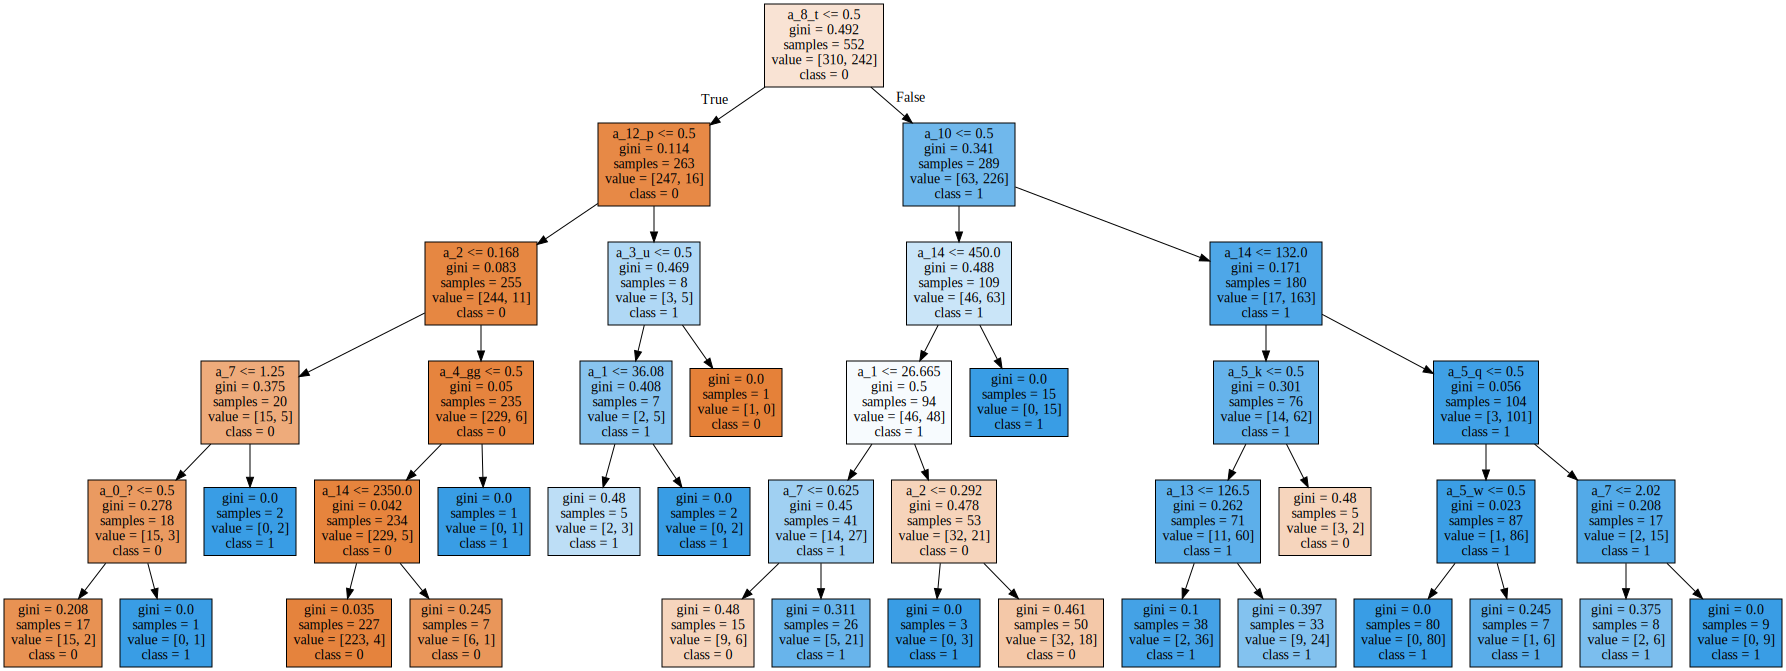

In [20]:
# DOT data
dot_data = export_graphviz(best_model, out_file=None, 
                                feature_names=x_train.columns,  
                                class_names=['0','1'],
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph